In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature
import time
import calendar

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# get lons and lats
# This will return the most recent data avail on mesonet
# this is my file path
ny_mesonet_data_path = "/home/aevans/nysm/archive/nysm/netcdf/proc"
ok_mesonet_data_path = "/home/aevans/landtype/geoinfo.csv"

In [4]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [5]:
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    "12"
)

In [6]:
gfs_fcast_and_error_df.keys()

Index(['t2m_GFS', 'd2m_GFS', 'u_total_GFS', 'u_dir_GFS', 'latitude',
       'longitude', 'new_tp_GFS', 'prmsl_GFS', 'orog', 't2m_error',
       'd2m_error', 'u_total_error', 'u_dir_error', 'new_tp_error',
       'prmsl_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm', 'u_dir_nysm',
       'new_tp_nysm', 'prmsl_nysm', 'lead_time_DAY', 'lead_time_HOUR',
       'lead_time_ONLY_HOURS'],
      dtype='object')

In [7]:
def main(nwp_df, variable, n_clusters):
    df = nwp_df.reset_index()
    months_df = (
        df.groupby([df.time.dt.month, "station"])[variable]
        .mean()
        .to_frame()
        .reset_index()
    )
    features = months_df.pivot(index="station", columns="time", values=variable)
    features = features.reset_index()
    stations = features["station"].tolist()
    features = features.drop(columns=["station"])
    # noramalize data
    scaler = preprocessing.MinMaxScaler()
    features_normal = scaler.fit_transform(features)
    # kmeans clustering
    inertia = []
    K = range(1, 20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(features_normal)
        kmeanModel.fit(features_normal)
        inertia.append(kmeanModel.inertia_)
    # Plot the elbow
    plt.plot(K, inertia, "bx-")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.show()
    # do actual cluster run
    kmeans = KMeans(n_clusters=n_clusters).fit(features_normal)
    labels = pd.DataFrame(
        kmeans.labels_
    )  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
    labeledClasses = pd.concat((features, labels), axis=1)
    labeledClasses = labeledClasses.rename({0: "labels"}, axis=1)
    plot_df = pd.read_csv(
        "/home/aevans/nwp_bias/src/landtype/notebooks/nysm_coords.csv"
    )
    plot_df["Cluster"] = labels
    colors = [
        "black",
        "blue",
        "green",
        "red",
        "orange",
        "yellow",
        "white",
        "purple",
        "cyan",
        "plum",
        "coral",
        "pink",
    ]
    legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    colordict = {}

    for x, _ in enumerate(colors):
        colordict.update({legend[x]: colors[x]})

    plot_df["color"] = plot_df["Cluster"].map(colordict)
    return plot_df

# K_means

In [8]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["latitude"].max() + 1
    latS = df["latitude"].min() - 1
    lonW = df["longitude"].max() + 1
    lonE = df["longitude"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["longitude"],
        y=df["latitude"],
        c=df["color"],
        s=80,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

# Precipitation

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

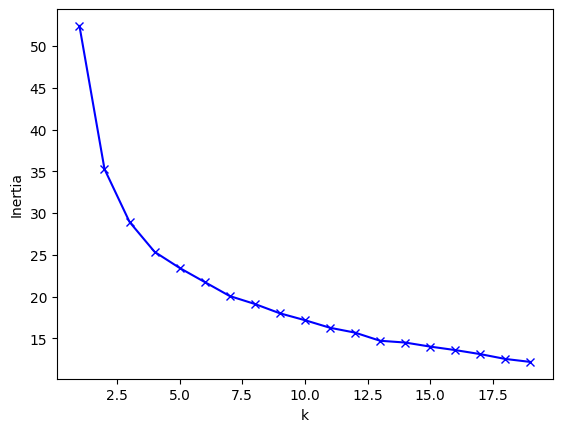

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# Precip
plot_df = main(gfs_fcast_and_error_df, "new_tp_nysm", 4)

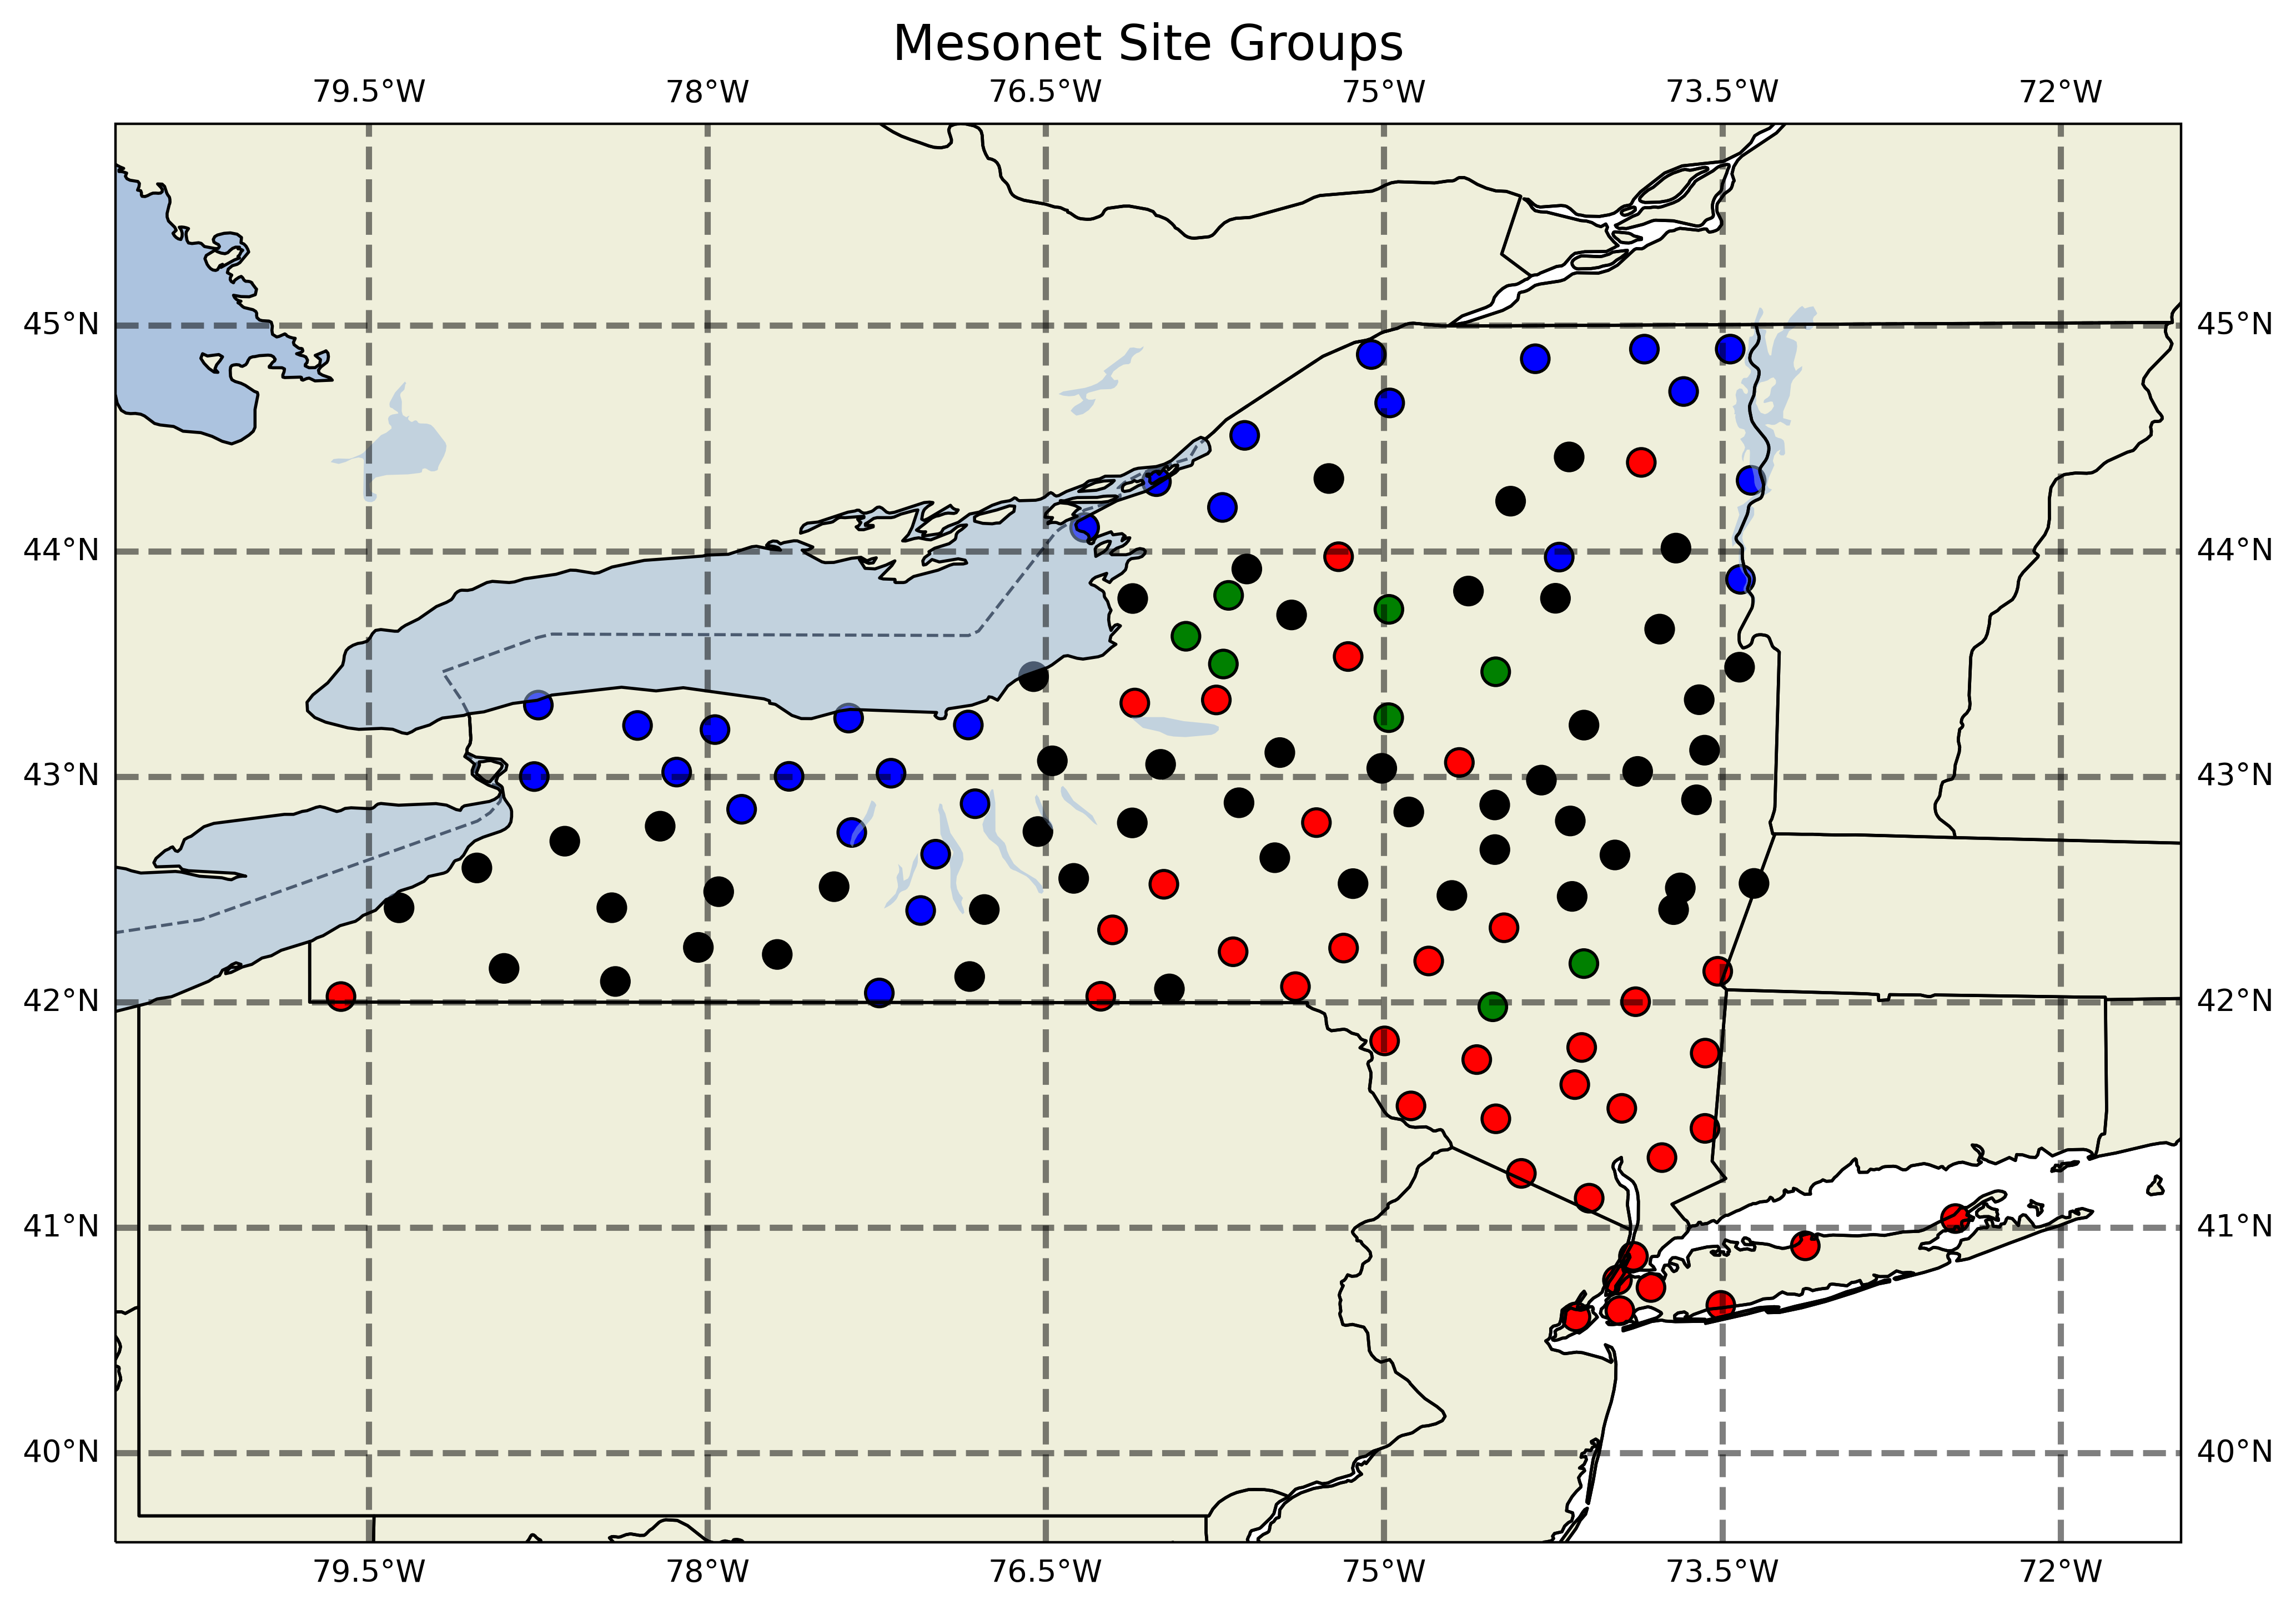

In [10]:
plurality_plot(plot_df)

# Temperature

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

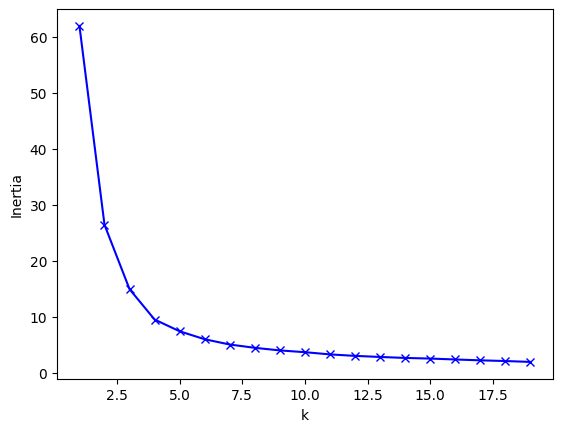

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


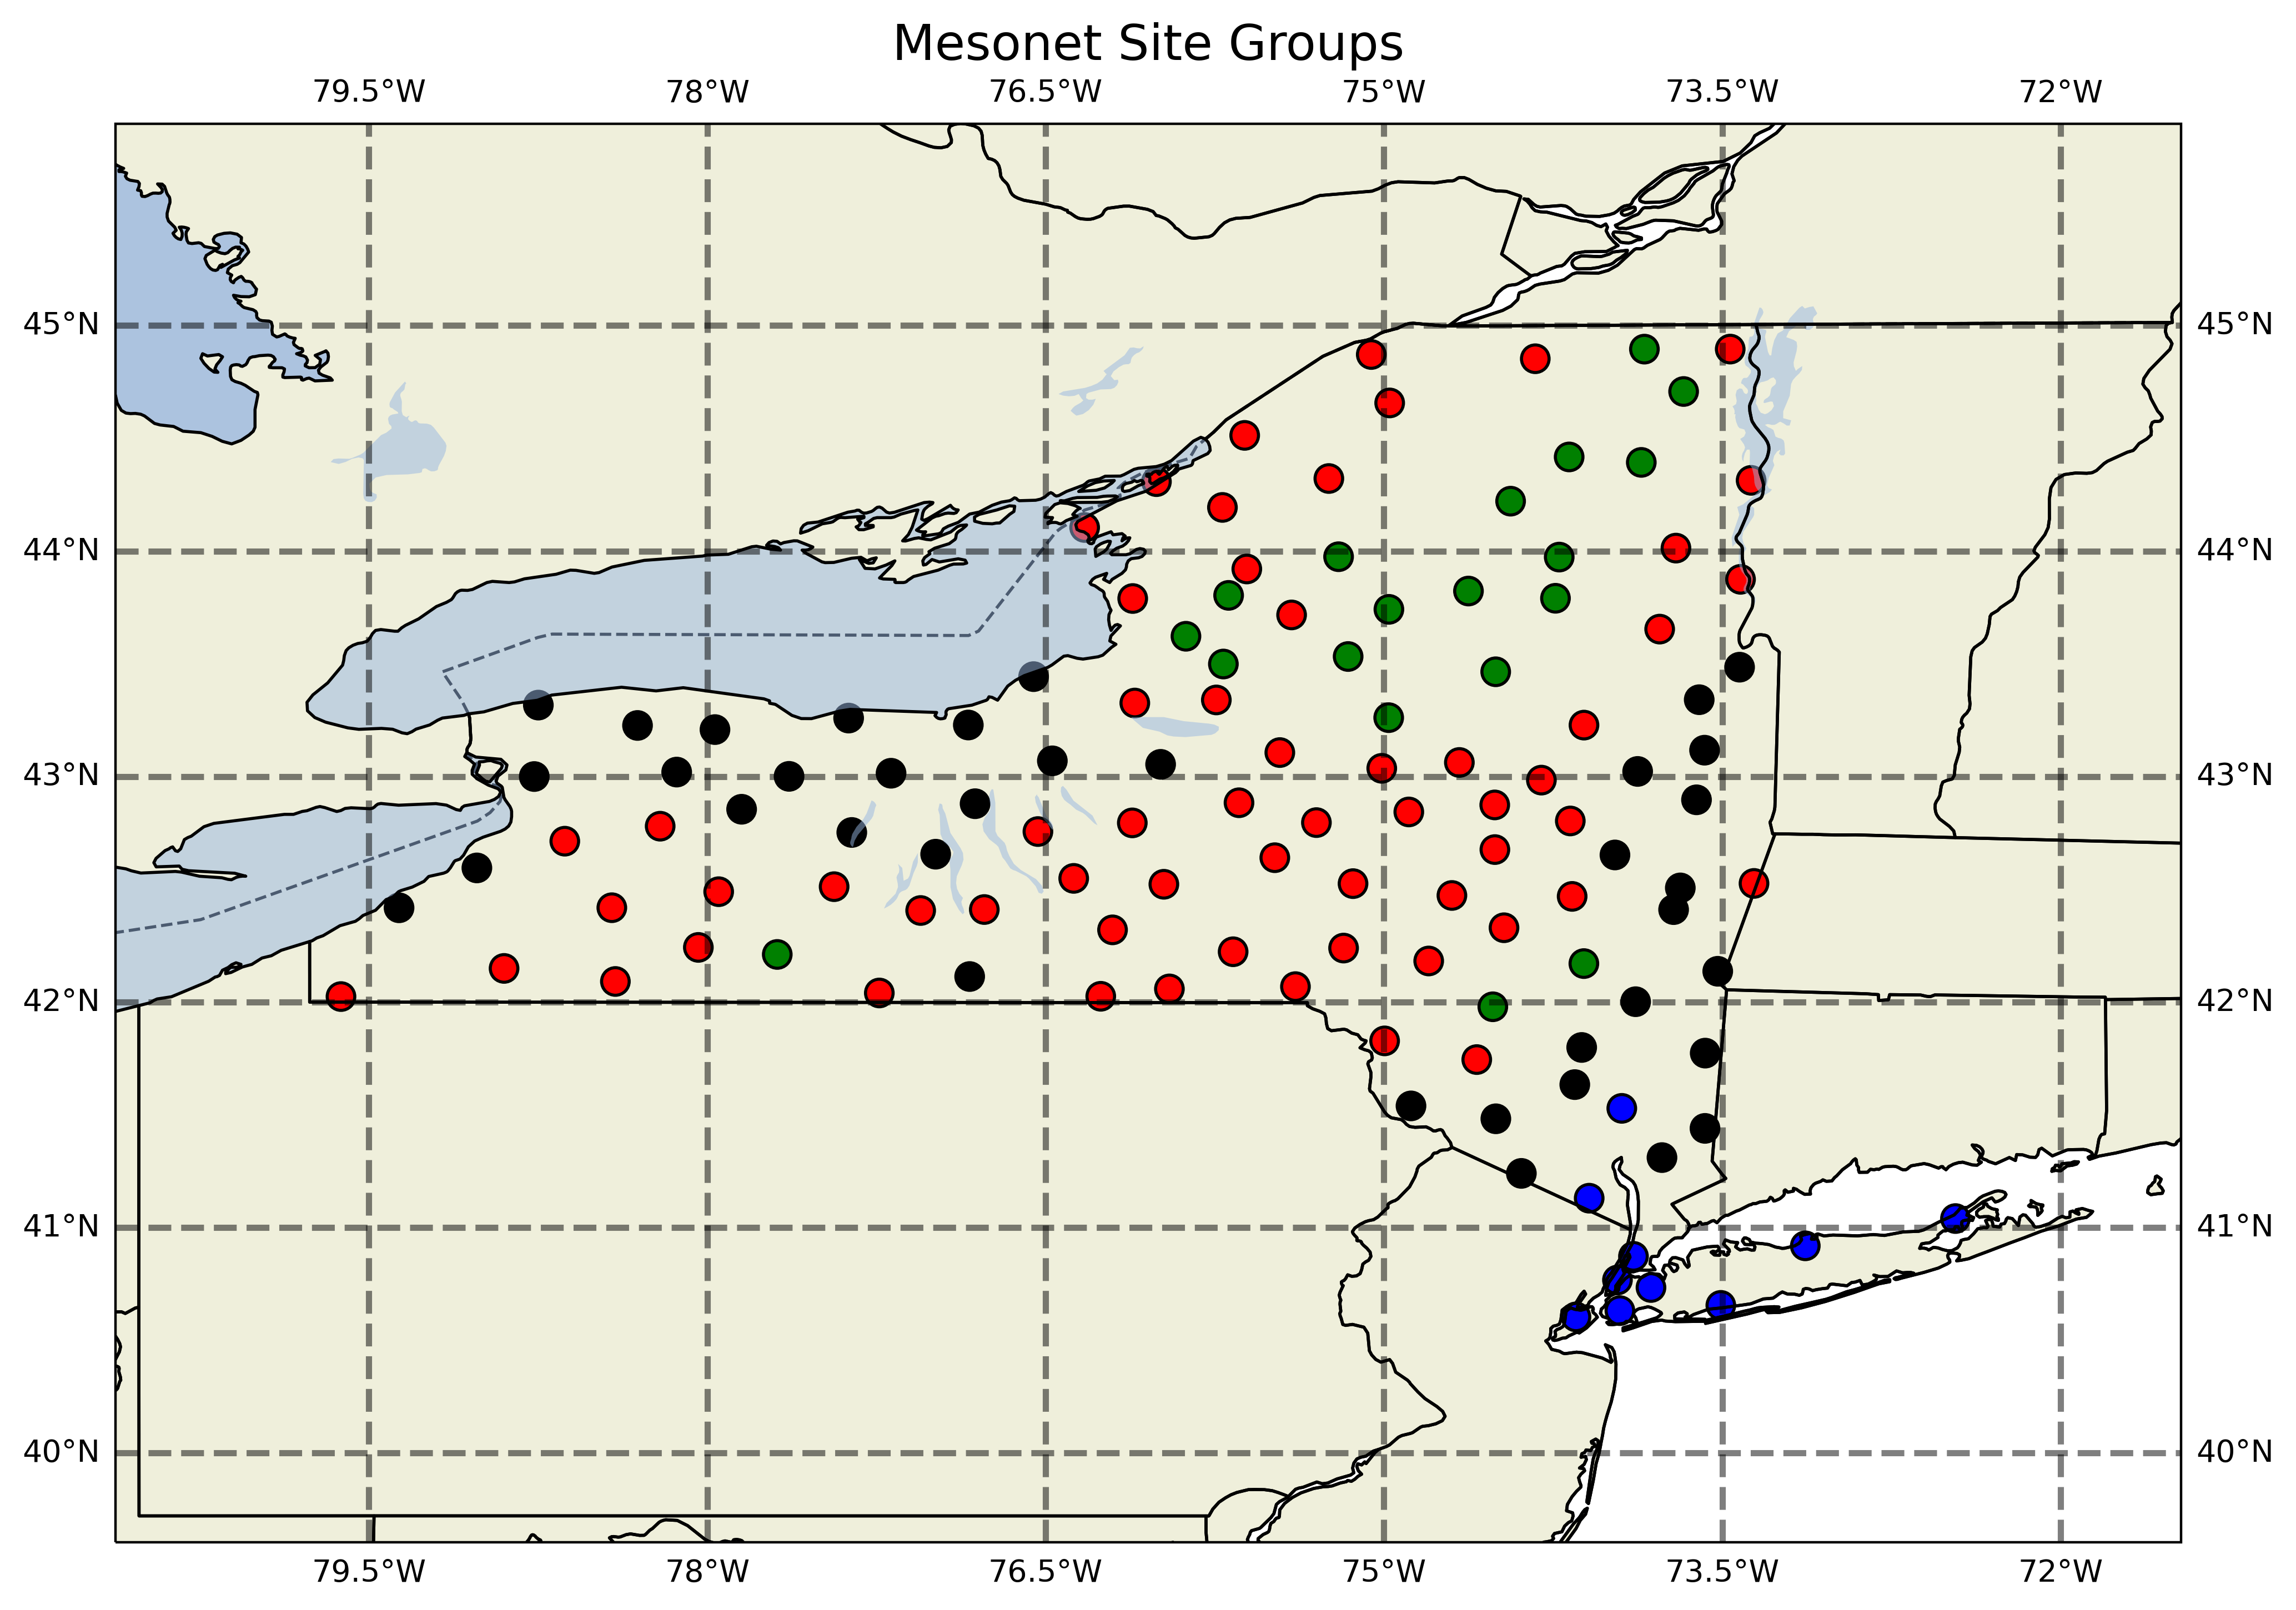

In [11]:
# temp
temp_df = main(gfs_fcast_and_error_df, "t2m_nysm", 4)
plurality_plot(temp_df)

# Wind Mag

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

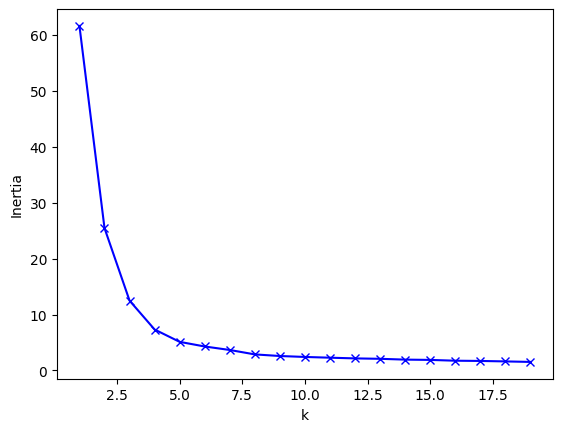

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# wind
wind_df = main(gfs_fcast_and_error_df, "u_total_nysm", 4)

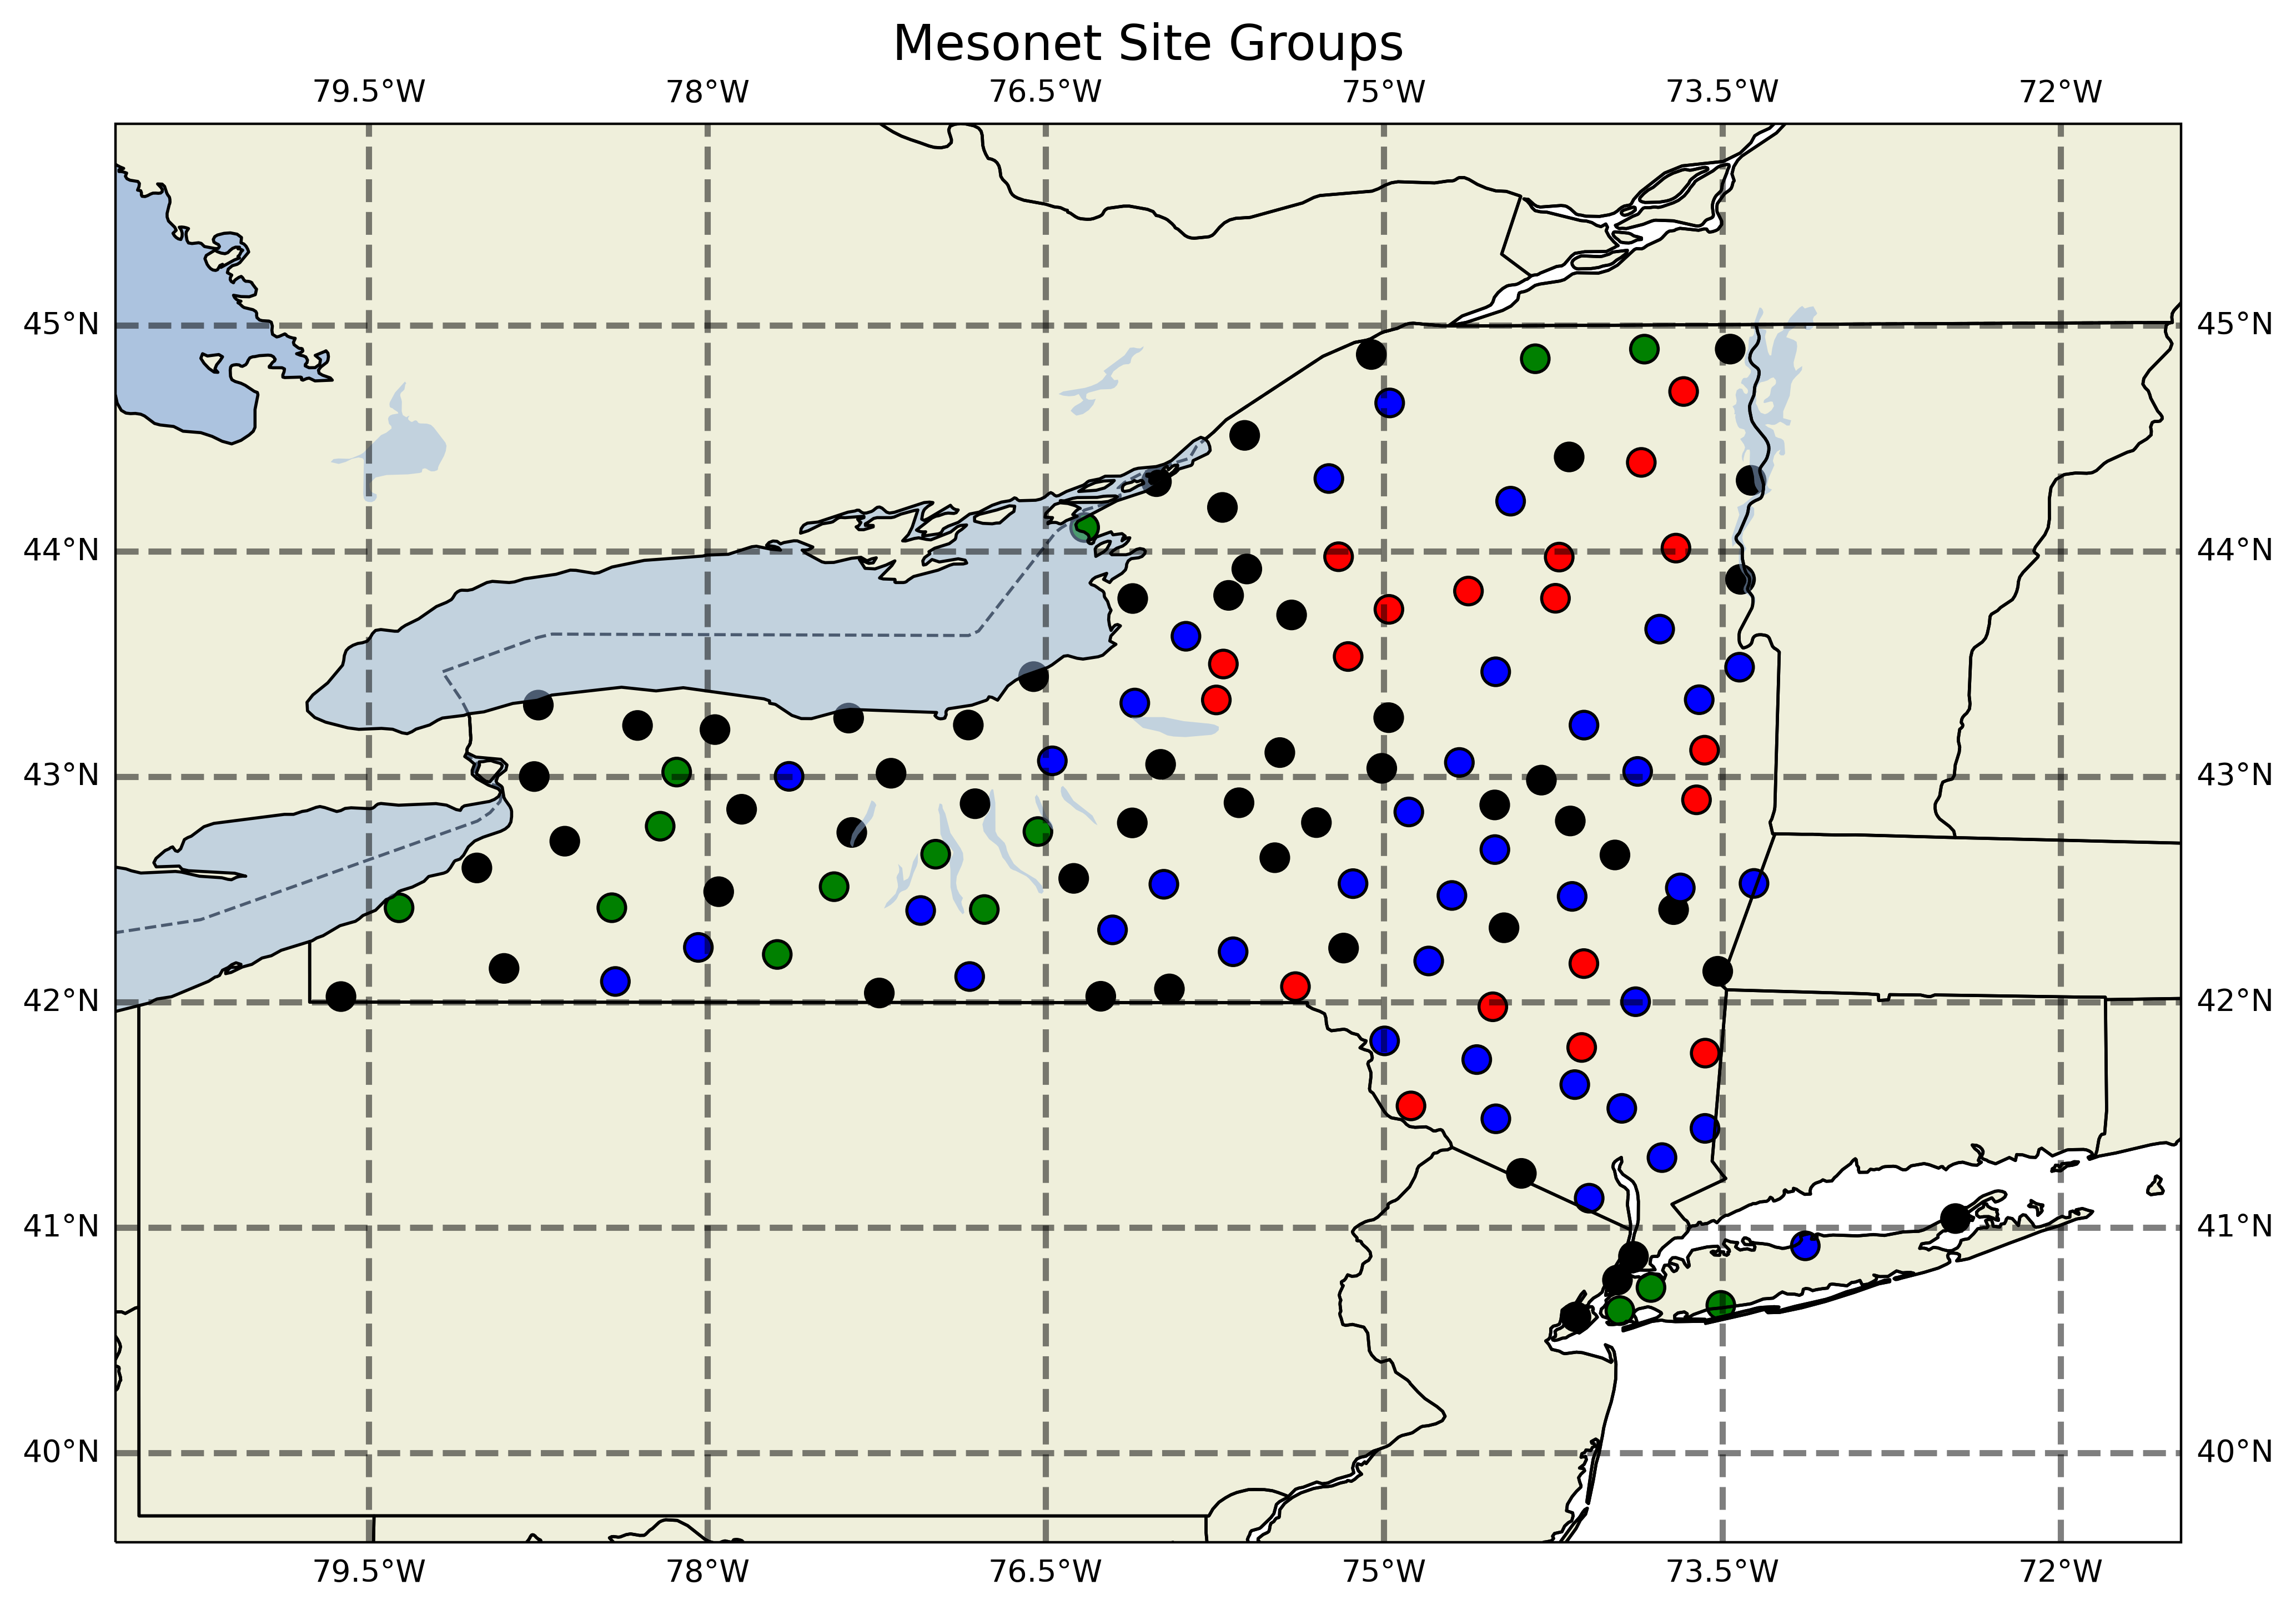

In [13]:
plurality_plot(wind_df)

# Pressure

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

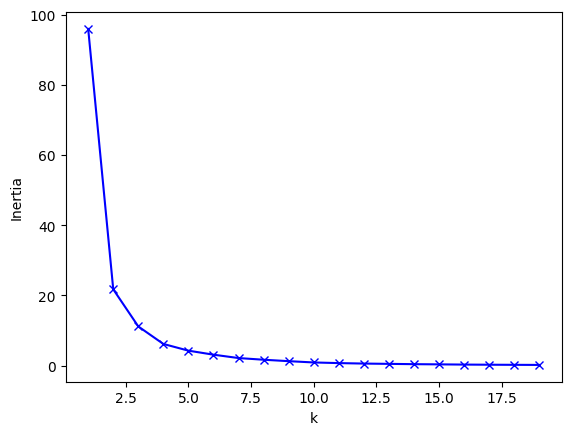

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
# pressure
pres_df = main(gfs_fcast_and_error_df, "prmsl_nysm", 4)

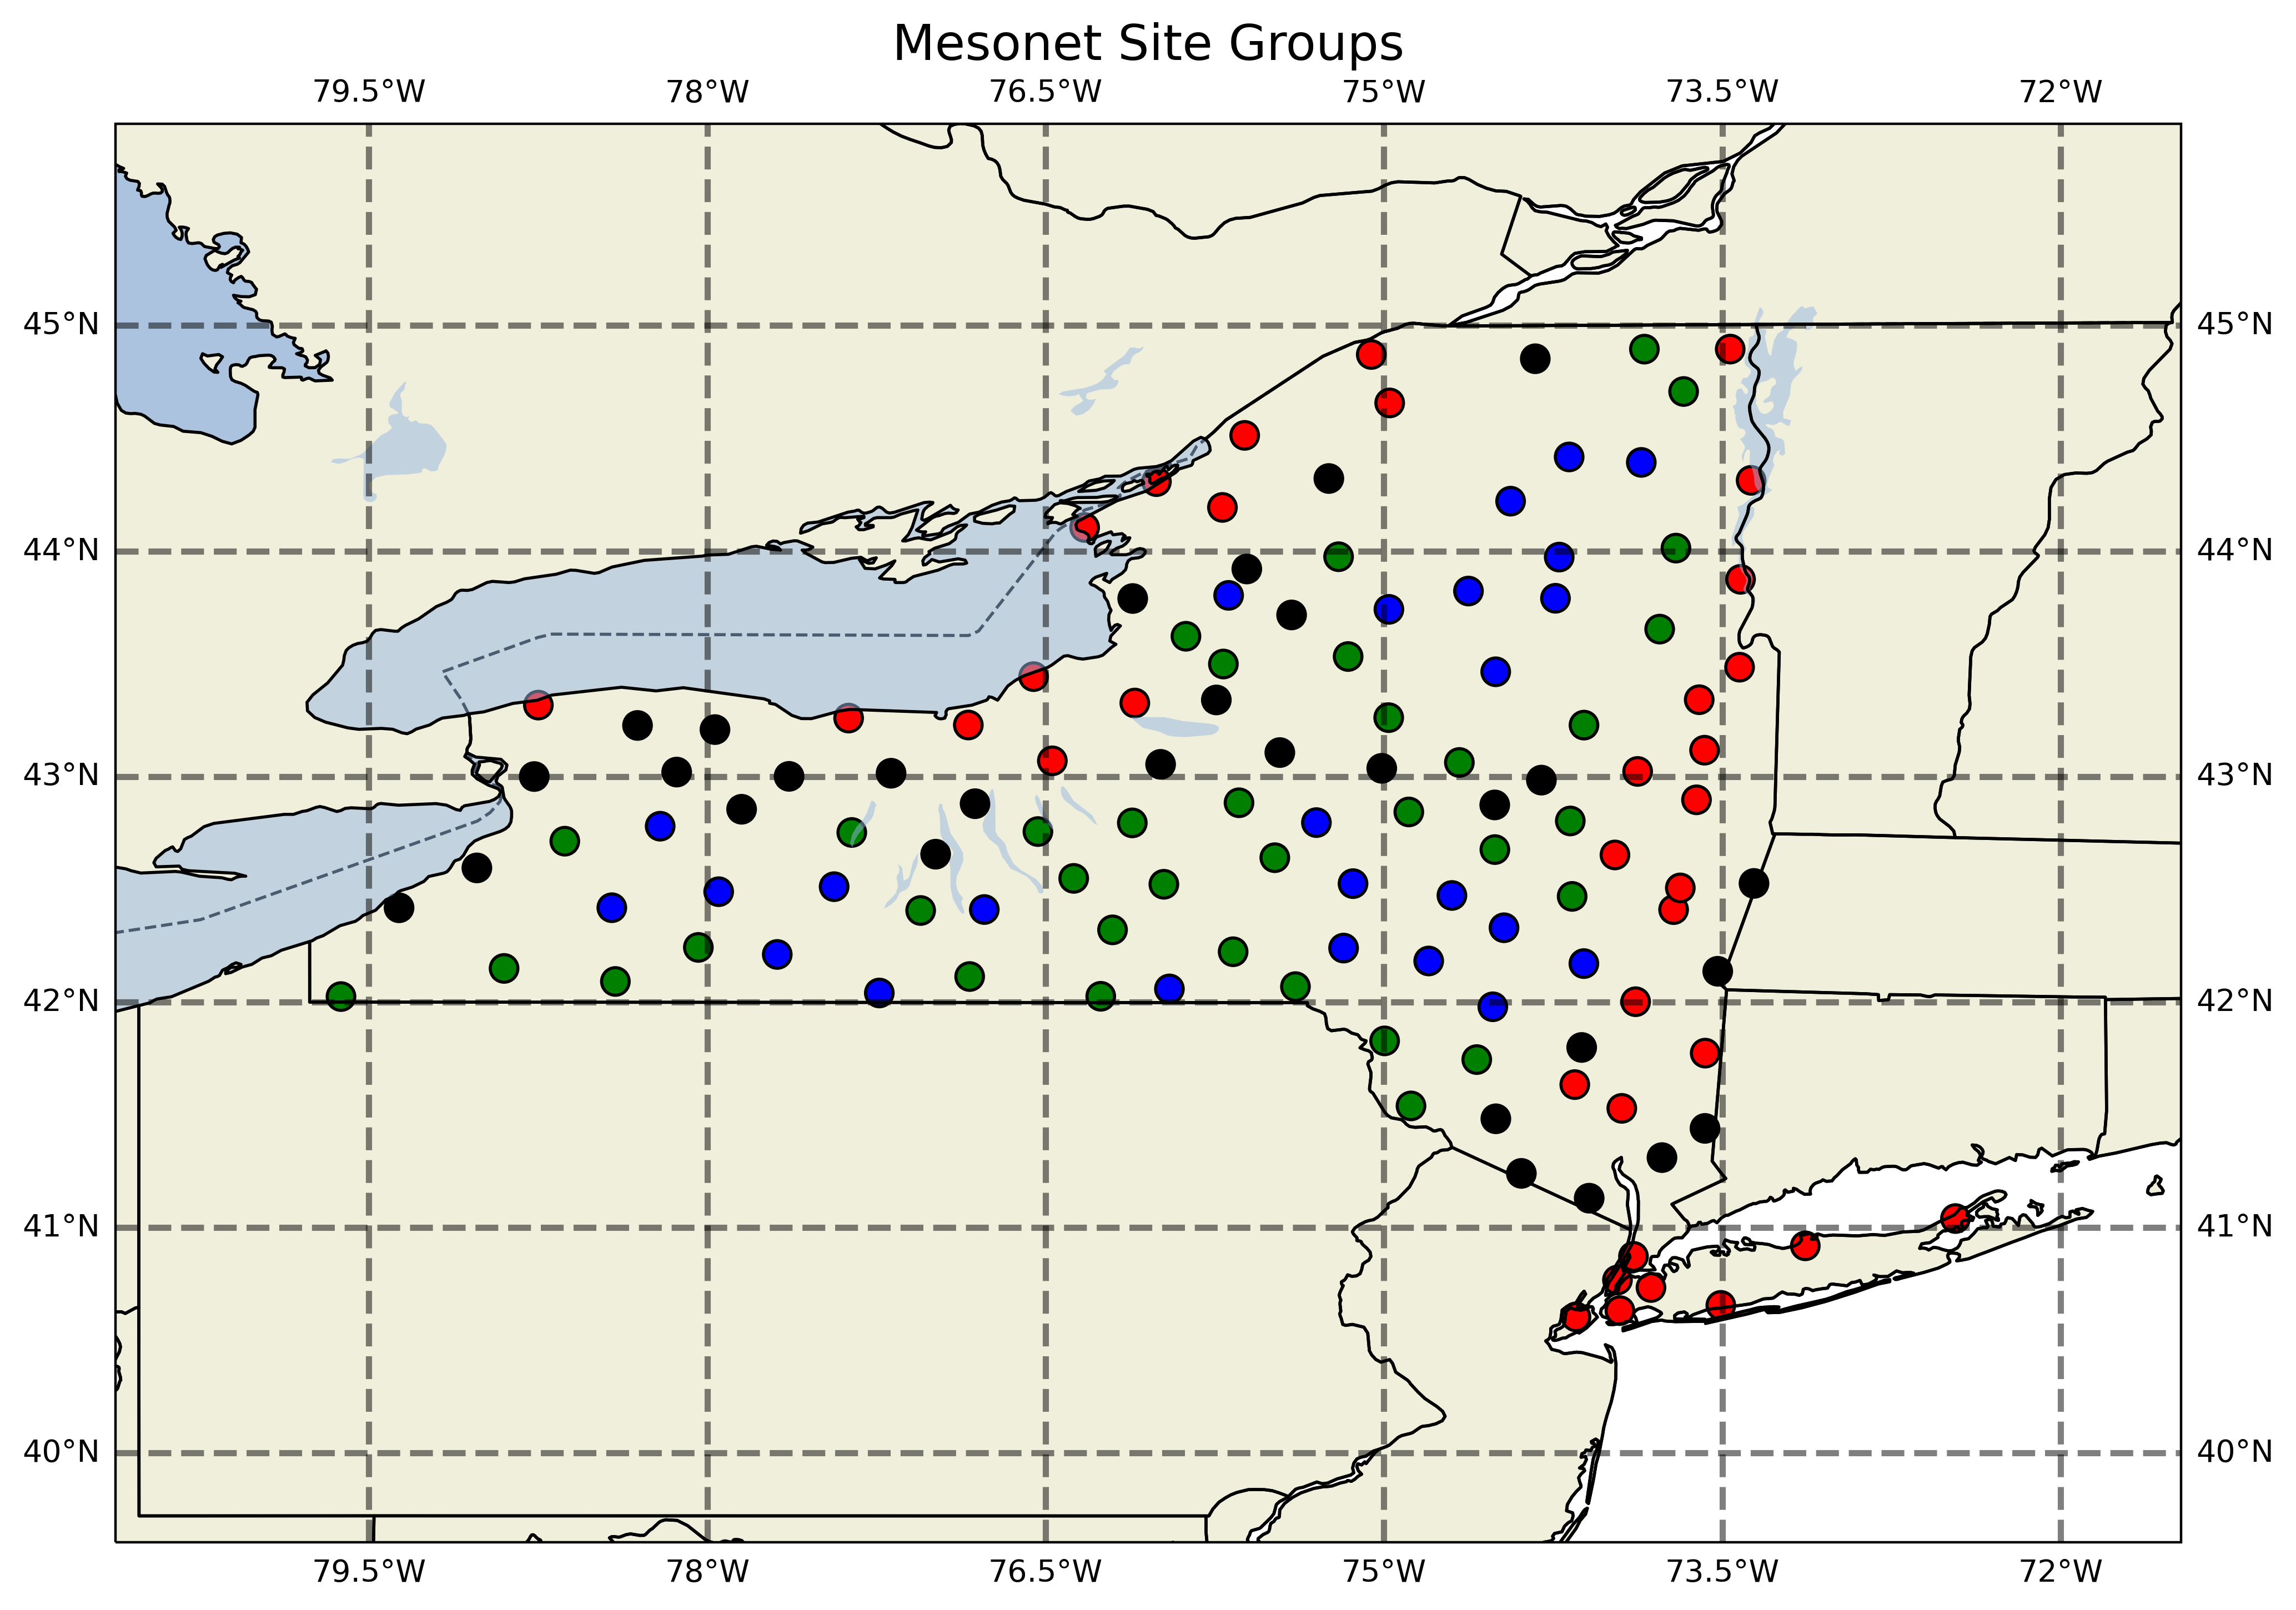

In [15]:
plurality_plot(pres_df)

# Wind Dir

In [16]:
# wind direction
dir_df = main(gfs_fcast_and_error_df, "u_dir_nysm", 4)

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


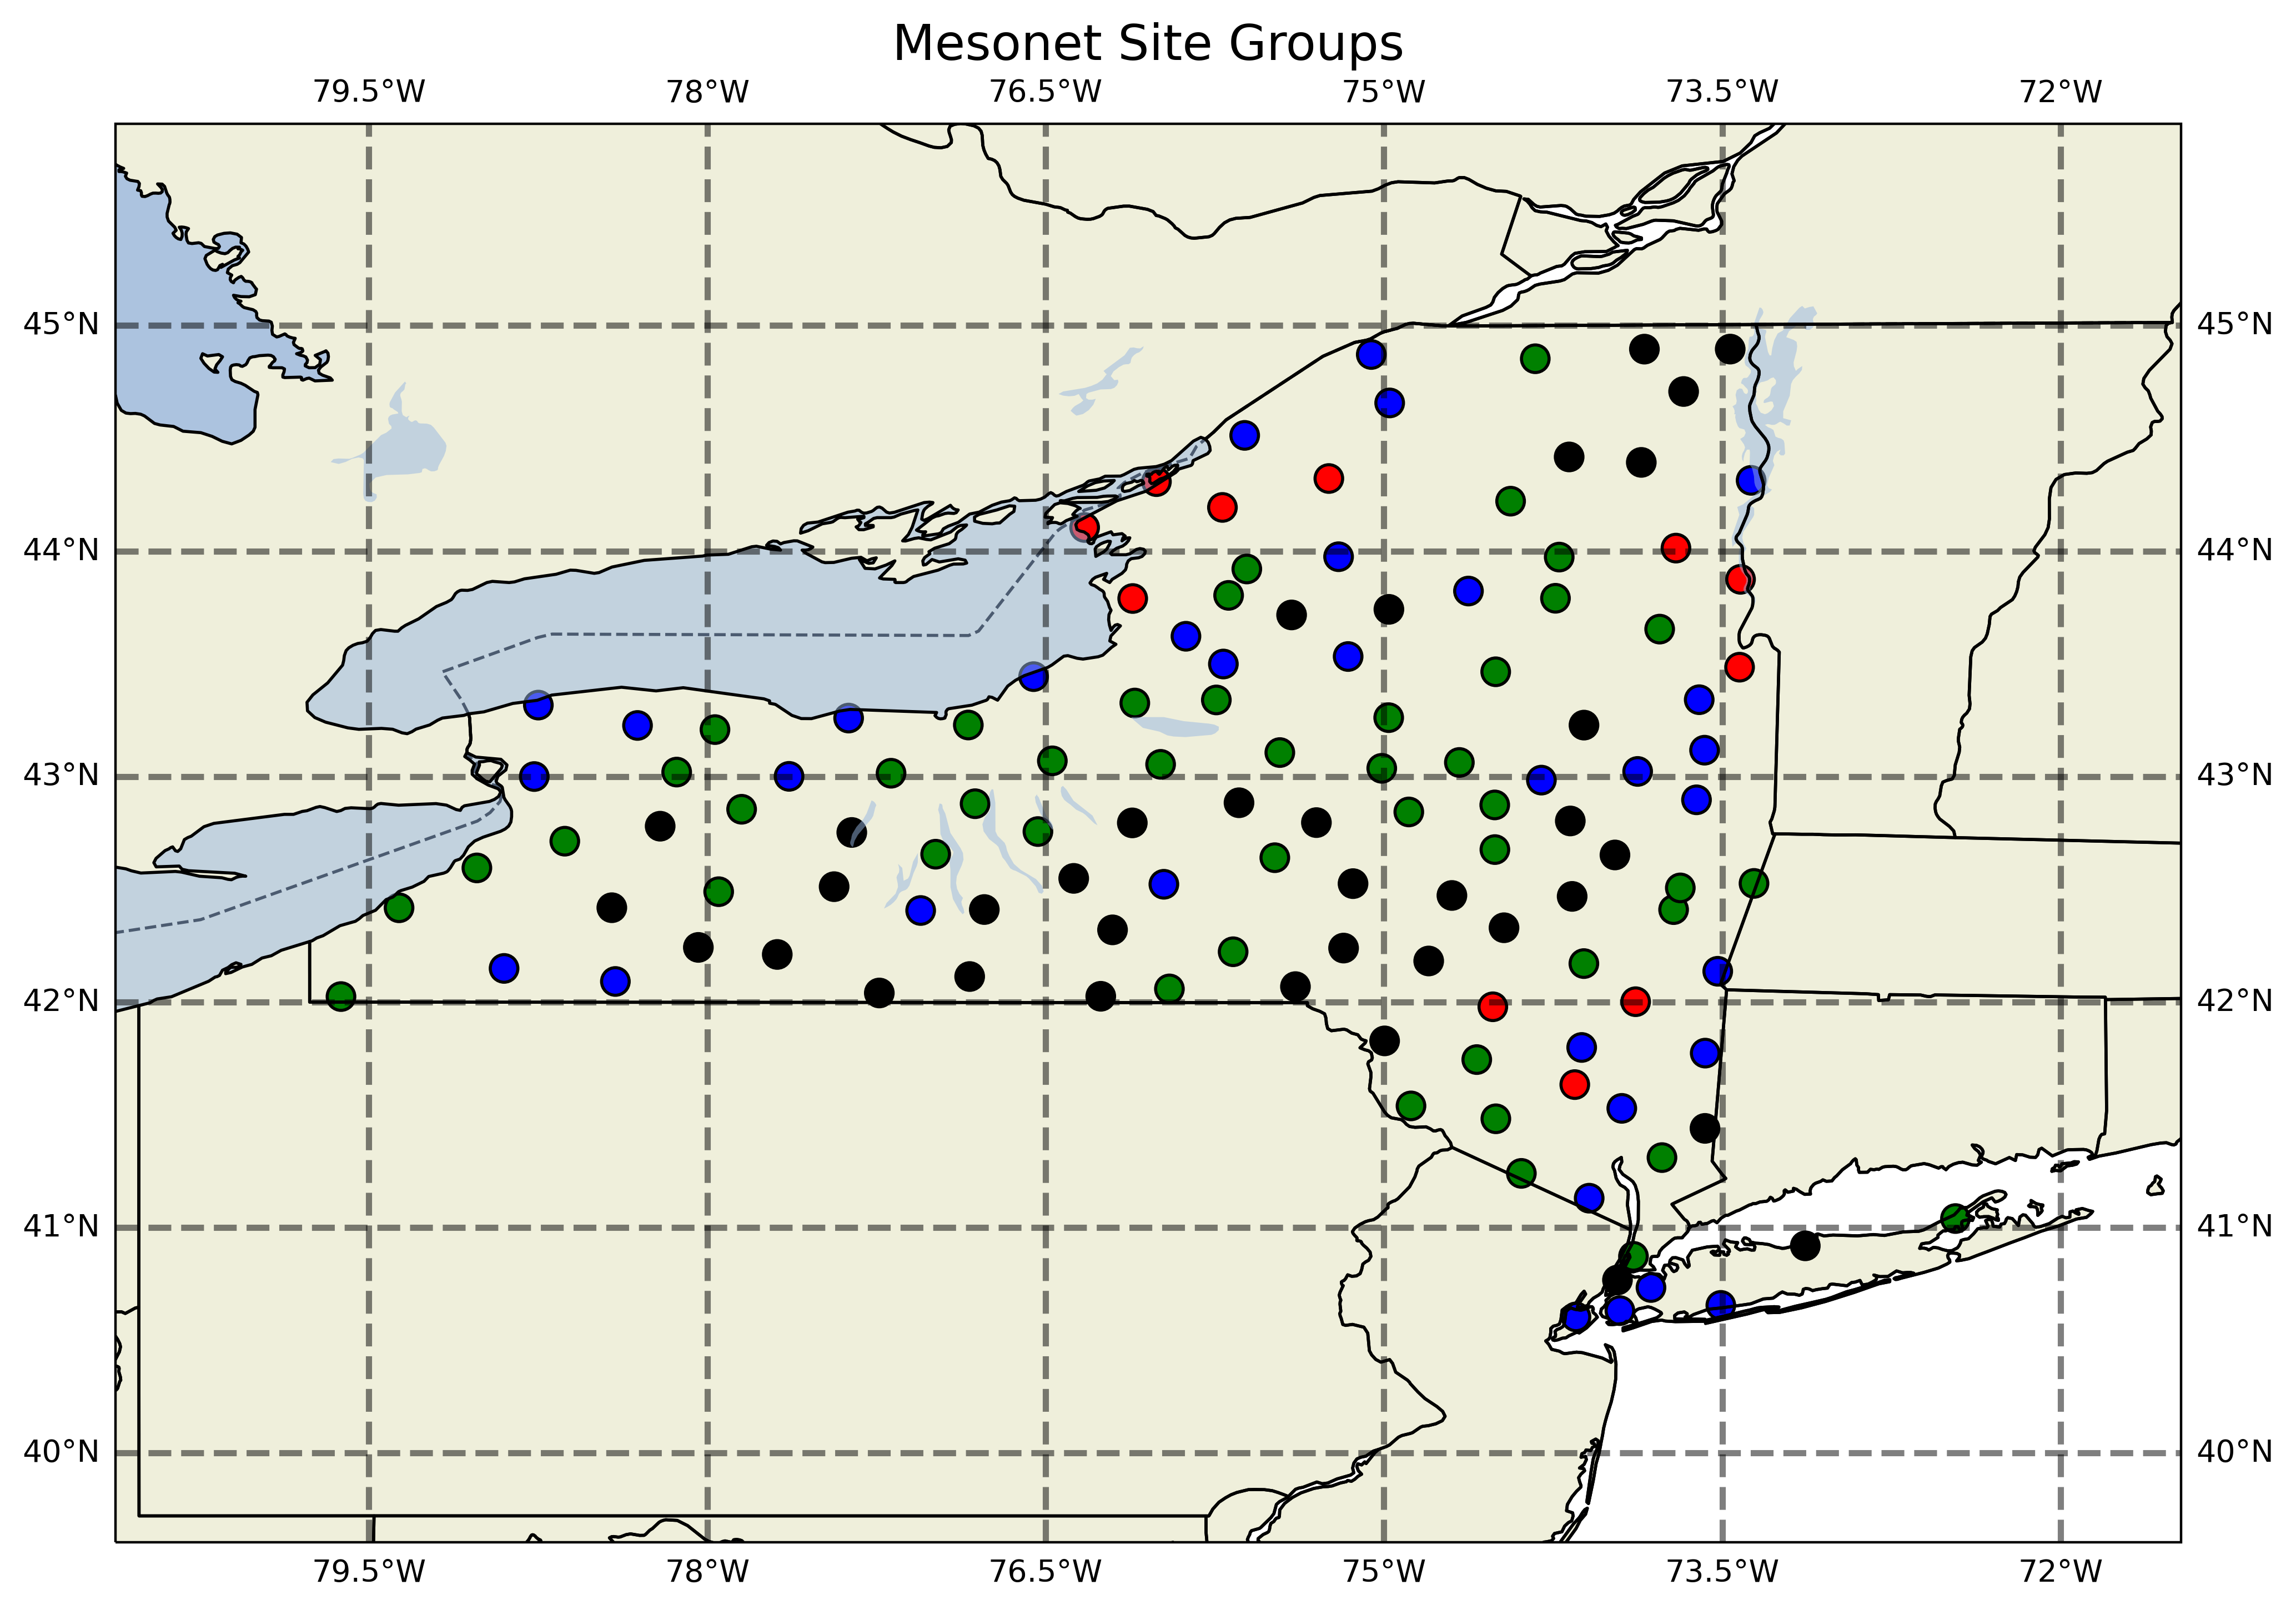

In [17]:
plurality_plot(dir_df)

# All met-vars combined

In [18]:
# Cluster on all weather data
# combine all dataframes
df = gfs_fcast_and_error_df.reset_index()
# get weather vars
precip_df = (
    df.groupby([df.time.dt.month, "station"])["new_tp_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
temp_df = (
    df.groupby([df.time.dt.month, "station"])["t2m_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
wind_df = (
    df.groupby([df.time.dt.month, "station"])["u_total_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
pres_df = (
    df.groupby([df.time.dt.month, "station"])["prmsl_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
dir_df = (
    df.groupby([df.time.dt.month, "station"])["u_dir_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)

# pivot dataframes
_precip = precip_df.pivot(index="station", columns="time", values="new_tp_nysm")
_temp = temp_df.pivot(index="station", columns="time", values="t2m_nysm")
_wind = wind_df.pivot(index="station", columns="time", values="u_total_nysm")
_pres = pres_df.pivot(index="station", columns="time", values="prmsl_nysm")
# _dir = dir_df.pivot(index = 'station', columns = 'time', values= 'u_dir_nysm')

In [19]:
# _dir

In [20]:
merged = _precip.merge(_temp, on="station")
merged = merged.merge(_wind, on="station")
merged = merged.merge(_pres, on="station")
# merged = merged.merge(_dir, on = 'station')

/tmp/tmp.elvrejuVxL/ipykernel_1033687/1563243562.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'2_x', '3_x', '9_x', '12_x', '1_x', '6_x', '4_x', '5_x', '7_x', '8_x', '11_x', '10_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged = merged.merge(_pres, on = 'station')


In [21]:
merged

time          1_x       2_x       3_x       4_x       5_x       6_x       7_x  \
station                                                                         
ADDI     0.198127  0.258266  0.209079  0.436544  0.357218  0.236504  0.619017   
ANDE     0.363131  0.354911  0.334886  0.593670  0.470945  0.402044  0.556195   
BATA     0.187769  0.303997  0.186836  0.363312  0.228467  0.233821  0.438435   
BEAC     0.306327  0.379321  0.255647  0.362976  0.448490  0.268323  0.500504   
BELD     0.300042  0.345131  0.255603  0.489140  0.420538  0.337044  0.550850   
...           ...       ...       ...       ...       ...       ...       ...   
WFMB     0.445384  0.382734  0.357350  0.526109  0.397165  0.461057  0.367114   
WGAT     0.351383  0.422376  0.366162  0.473060  0.394438  0.405856  0.562155   
WHIT     0.306366  0.313506  0.253471  0.508066  0.285760  0.510153  0.454791   
WOLC     0.319586  0.321816  0.260479  0.333238  0.217990  0.255802  0.280635   
YORK     0.202140  0.250178  0.153044  0.350202  0.225314  0.380105  0.568793   

time          8_x       9_x      10_x  ...          3_y          4_y  \
station                                ...                             
ADDI     0.380765  0.447538  0.509222  ...   957.458651   953.673385   
ANDE     0.665287  0.550495  0.568654  ...   955.620962   952.042455   
BATA     0.400344  0.323694  0.515813  ...   985.102602   980.831257   
BEAC     0.658690  0.498904  0.526955  ...  1007.251514  1002.734163   
BELD     0.609693  0.459713  0.643855  ...   961.535129   957.720910   
...           ...       ...       ...  ...          ...          ...   
WFMB     0.350716  0.360468  0.722954  ...   942.431556   939.691874   
WGAT     0.577214  0.464277  0.736653  ...   964.144473   960.394447   
WHIT     0.552869  0.435319  0.505373  ...  1013.550669  1008.726806   
WOLC     0.297470  0.174242  0.200808  ...  1003.796326   999.121766   
YORK     0.465000  0.313978  0.532594  ...   997.178457   992.590161   

time             5_y          6_y          7_y          8_y          9_y  \
station                                                                    
ADDI      957.385227   956.303795   957.753887   957.832865   959.887245   
ANDE      956.050226   954.947367   956.469920   956.708425   959.012066   
BATA      983.721382   981.924872   983.239981   983.346158   985.637769   
BEAC     1005.711472  1003.619706  1004.650295  1004.747280  1008.136414   
BELD      961.507224   960.398239   961.727319   961.942905   964.388700   
...              ...          ...          ...          ...          ...   
WFMB      943.909497   942.890446   944.937237   945.115446   946.959989   
WGAT      964.131788   962.797039   964.303087   964.521011   966.831931   
WHIT     1011.393586  1009.051226  1010.287986  1010.534688  1013.946376   
WOLC     1001.750411   999.621730  1000.644216  1000.899995  1003.705609   
YORK      995.181629   993.227780   994.409433   994.637723   997.117090   

time            10_y         11_y         12_y  
station                                         
ADDI      957.309060   957.892781   955.772983  
ANDE      956.134824   956.141171   953.722124  
BATA      983.429580   984.526377   982.727343  
BEAC     1006.391908  1007.569040  1006.629715  
BELD      961.497214   961.823582   960.117597  
...              ...          ...          ...  
WFMB      943.720874   942.682713   940.765426  
WGAT      964.138280   964.285707   962.468351  
WHIT     1012.513842  1013.700985  1012.782592  
WOLC     1001.529449  1003.099874  1001.361644  
YORK      995.146247   996.671587   995.062385  

[126 rows x 48 columns]

In [22]:
features = merged.copy()
features = features.reset_index()
stations = features["station"].tolist()

In [23]:
features = features.drop(columns=["station"])
feastures = features.astype(float)
features.keys()

Index(['1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x',
       '11_x', '12_x', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y',
       '9_y', '10_y', '11_y', '12_y', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x',
       '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '1_y', '2_y', '3_y', '4_y',
       '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y'],
      dtype='object', name='time')

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

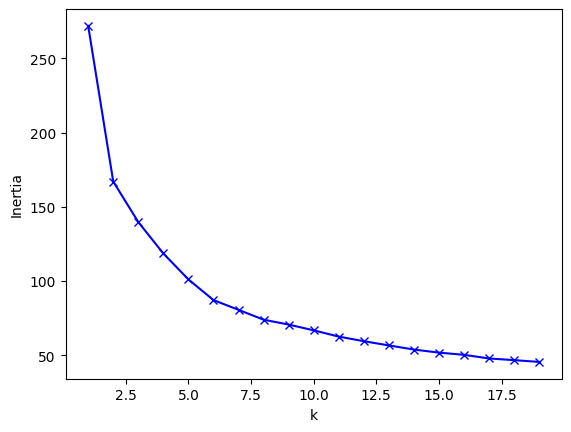

In [24]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(features)
# kmeans clustering
inertia = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, inertia, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [25]:
# let's say there are 6 clusters
# do actual cluster run
kmeans = KMeans(n_clusters=6).fit(features_normal)
labels = pd.DataFrame(
    kmeans.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledClasses = pd.concat((features, labels), axis=1)
labeledClasses = labeledClasses.rename({0: "labels"}, axis=1)
plot_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/notebooks/nysm_coords.csv")
plot_df["Cluster"] = labels
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

plot_df["color"] = plot_df["Cluster"].map(colordict)

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


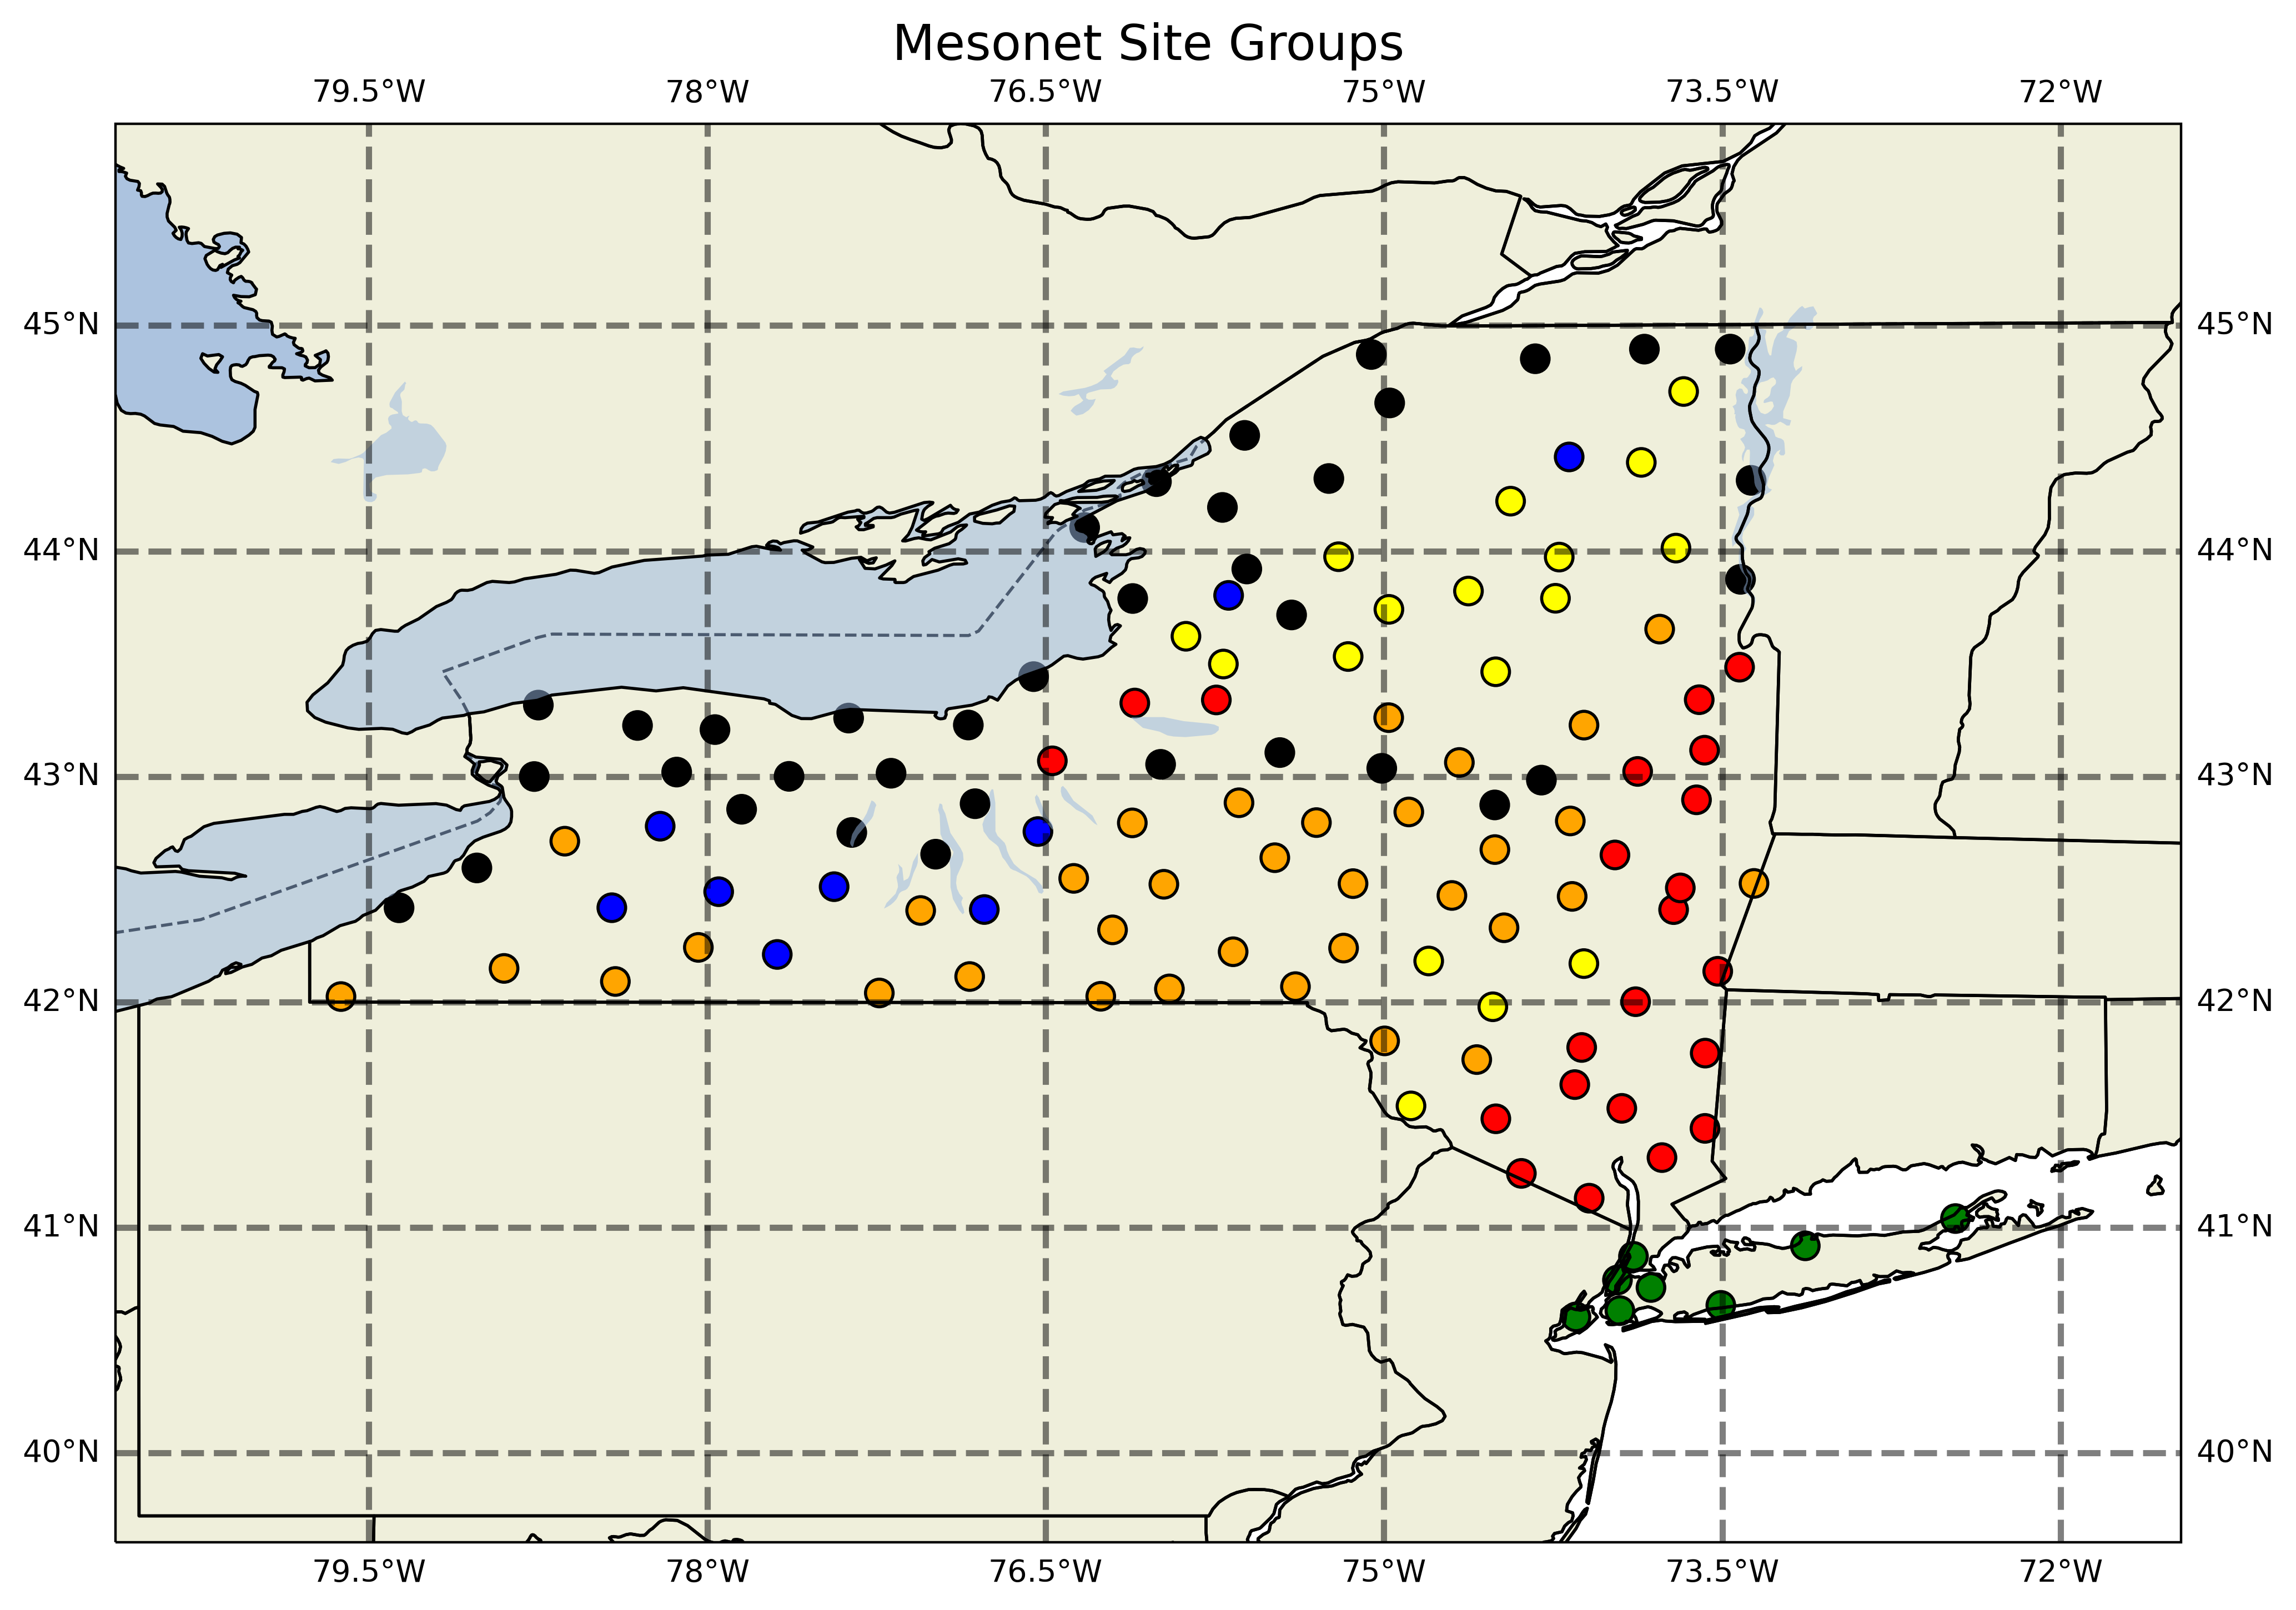

In [26]:
plurality_plot(plot_df)

In [27]:
from kmeans_interp.kmeans_feature_imp import KMeansInterp

kms = KMeansInterp(
    n_clusters=len(plot_df["Cluster"].unique()),
    random_state=1,
    ordered_feature_names=features.keys(),
    feature_importance_method="wcss_min",
).fit(features)
labels = kms.labels_
plot_df["Cluster"] = labels

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
centroids = kms.cluster_centers_
num_clusters = kms.n_clusters
n_features = kms.n_features_in_
centroids_labels = pd.DataFrame(
    {
        "centroid_dim": np.array(
            [centroids[i] for i in range(len(centroids))]
        ).flatten(),
        "cluster_label": np.array(
            [np.repeat(label, n_features) for label in range(num_clusters)]
        ).flatten(),
    }
)

In [29]:
centroids_labels[centroids_labels["cluster_label"] == 0]["centroid_dim"]

0        0.312390
1        0.350722
2        0.290494
3        0.408218
4        0.322582
5        0.318278
6        0.469253
7        0.480109
8        0.393690
9        0.533556
10       0.392177
11       0.372447
12      -2.776438
13      -1.085978
14       3.187441
15       8.214581
16      15.382539
17      20.752463
18      23.746594
19      22.732695
20      18.375832
21      12.152994
22       4.586036
23       0.877251
24       3.170235
25       3.141889
26       3.536930
27       3.444181
28       2.844772
29       2.532376
30       2.311632
31       2.219645
32       2.386826
33       2.688623
34       2.965751
35       3.004499
36    1008.309621
37    1008.866165
38    1008.036684
39    1003.479182
40    1006.305781
41    1004.057221
42    1005.165381
43    1005.471275
44    1008.580625
45    1006.764205
46    1008.004258
47    1006.909566
Name: centroid_dim, dtype: float64

In [30]:
kms.feature_importances_[1][:-1]

[('9_y', 968.2986167816775),
 ('11_y', 966.1848115152782),
 ('3_y', 966.0765576084644),
 ('8_y', 966.0468410976855),
 ('2_y', 966.0434141848984),
 ('7_y', 965.8618060782048),
 ('10_y', 965.7562657894377),
 ('5_y', 965.7316713485292),
 ('1_y', 965.5589029426948),
 ('6_y', 964.4181417529455),
 ('12_y', 964.4095441898055),
 ('4_y', 962.1480682123185),
 ('7_y', 21.550538764524433),
 ('8_y', 20.54113546976246),
 ('6_y', 18.901089164005747),
 ('9_y', 16.52374071854177),
 ('5_y', 14.236254882813101),
 ('10_y', 10.52516497904975),
 ('4_y', 6.432603198194852),
 ('1_y', 4.599579270109628),
 ('3_x', 3.143554923533293),
 ('4_x', 3.0407355059619854),
 ('2_x', 2.849215516508929),
 ('1_x', 2.8252512293265855),
 ('2_y', 2.825189584871355),
 ('12_x', 2.6819370606373116),
 ('11_x', 2.6386564082153168),
 ('5_x', 2.5294007738851376),
 ('10_x', 2.393783192662347),
 ('11_y', 2.352422656553435),
 ('6_x', 2.1869323259975757),
 ('9_x', 2.0476688484157766),
 ('7_x', 1.8908839029445246),
 ('8_x', 1.8463117692055

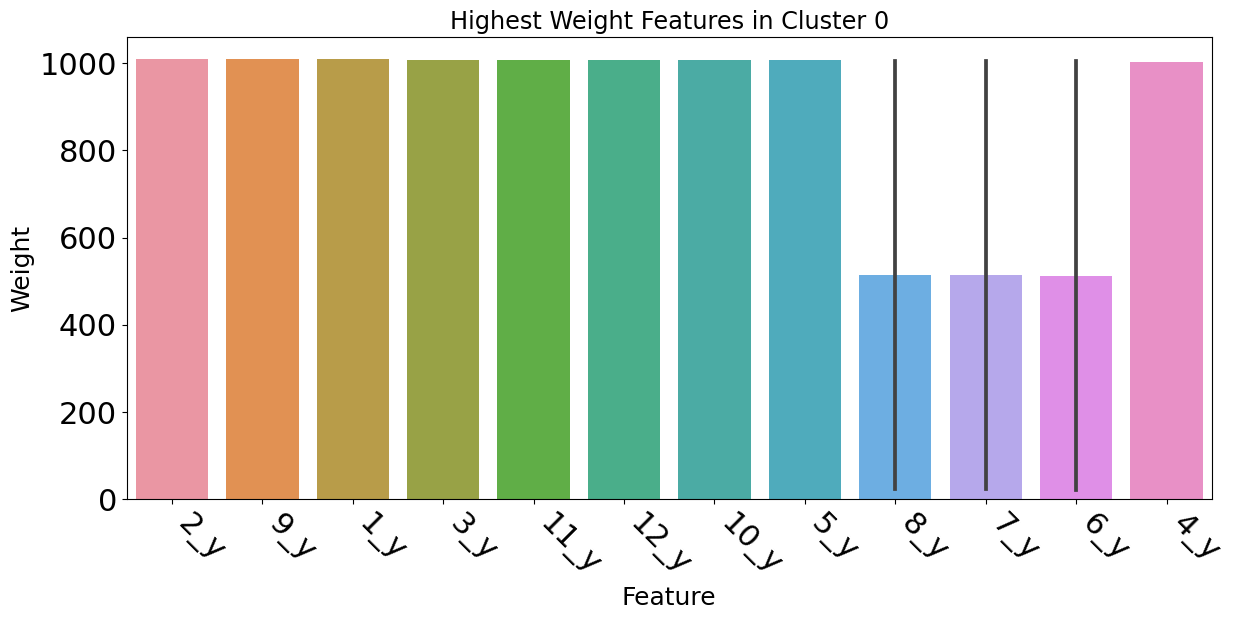

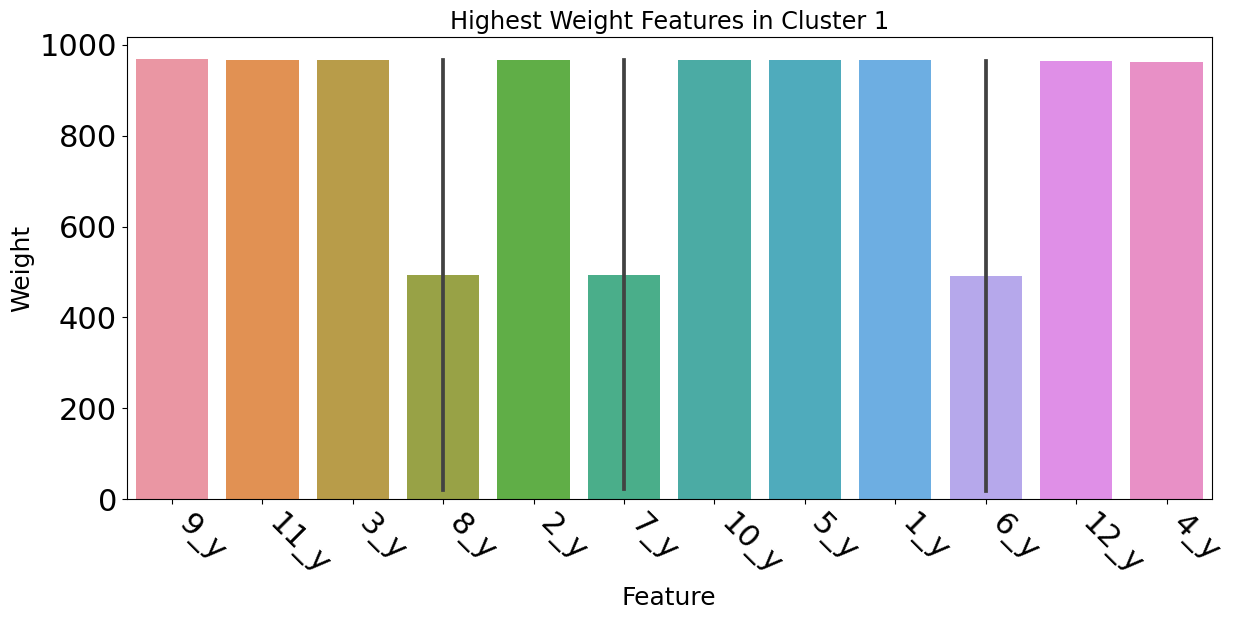

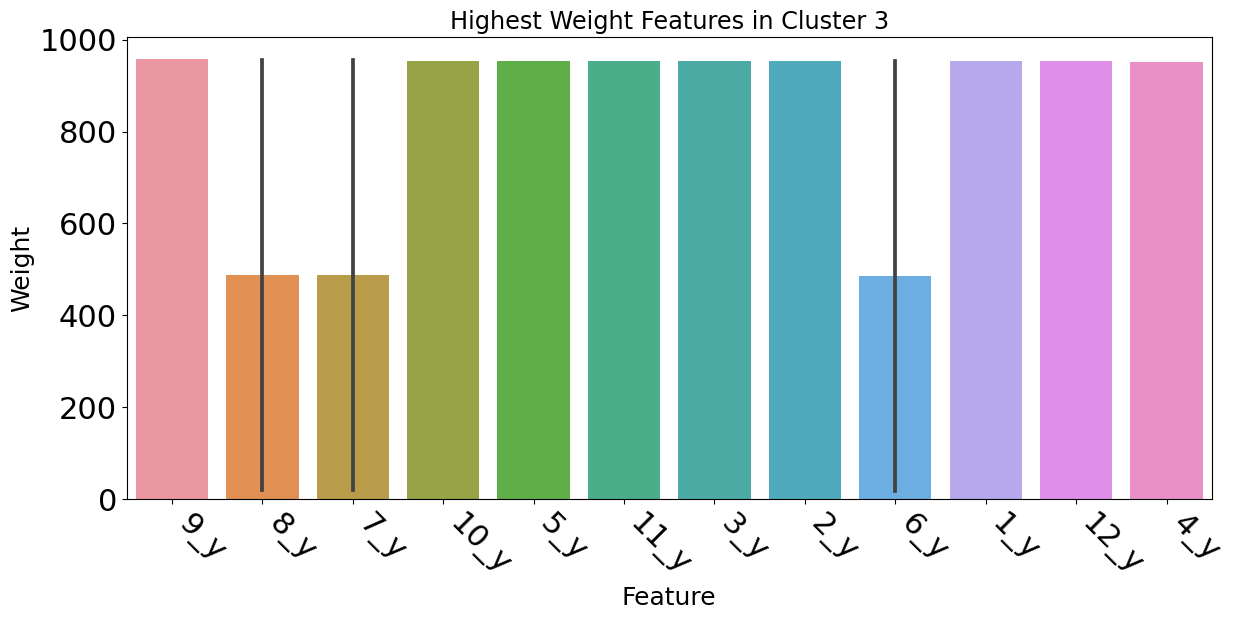

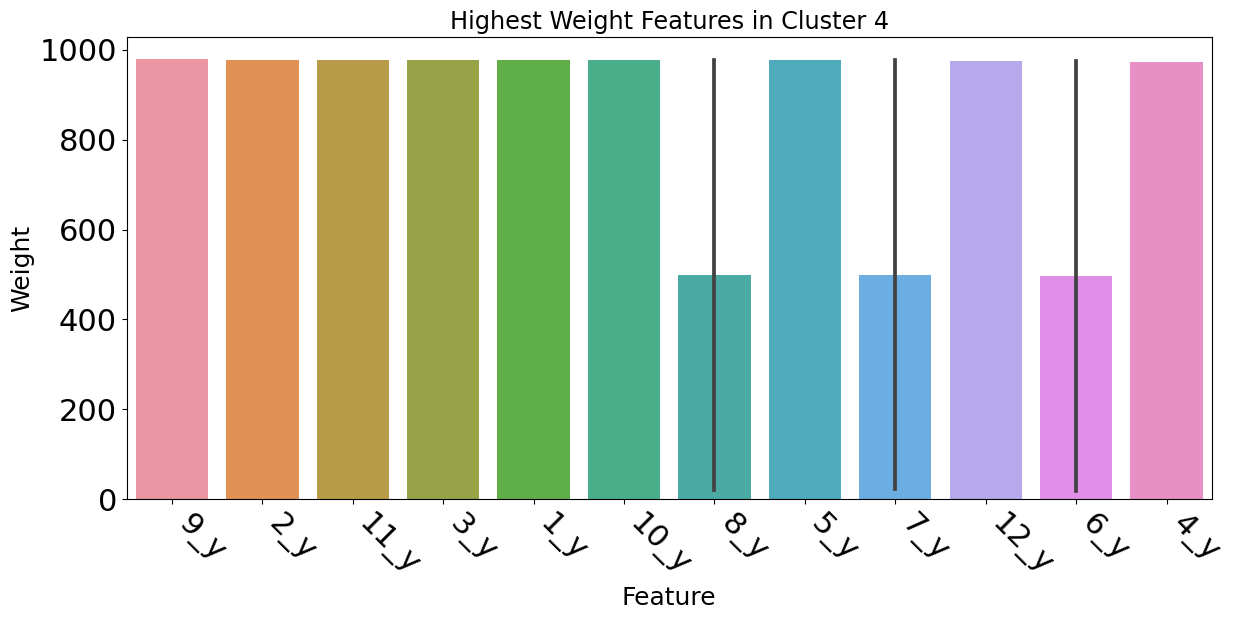

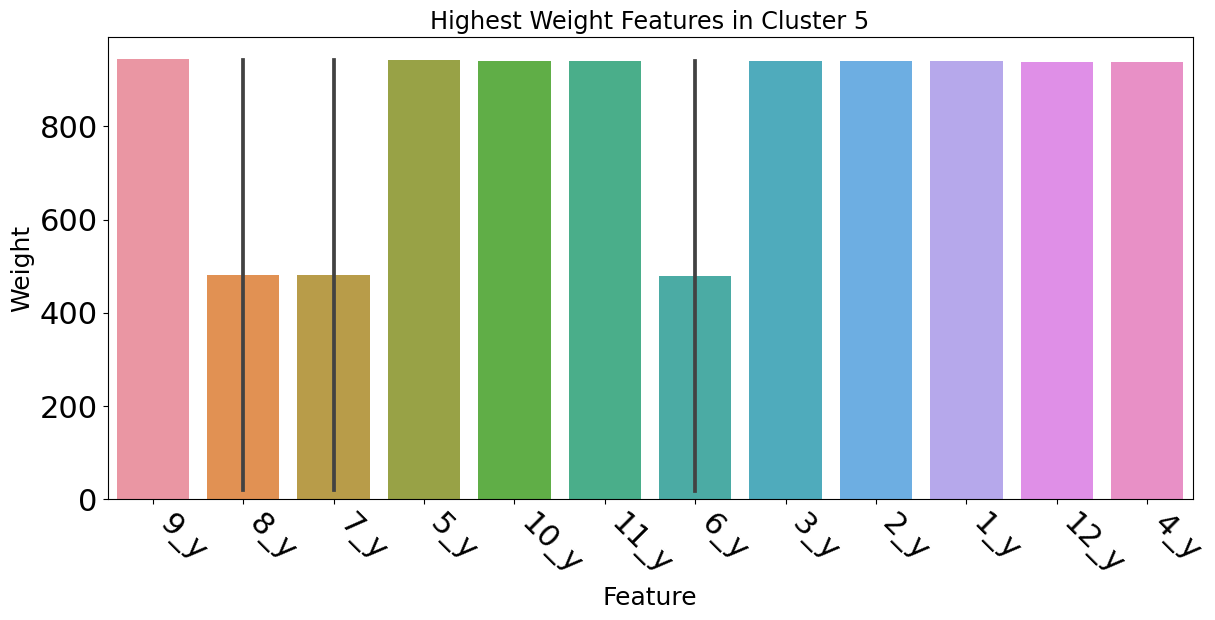

In [31]:
for cluster_label, feature_weights in kms.feature_importances_.items():
    df_feature_weight = pd.DataFrame(
        feature_weights[:15], columns=["Feature", "Weight"]
    )
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left")
    ax.tick_params(axis="both", which="major", labelsize=22)
    plt.title(
        f"Highest Weight Features in Cluster {cluster_label}", fontsize="xx-large"
    )
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Weight", fontsize=18)

    plt.show()

    print("\n\n")